In [1]:
import os
import pickle
import torch
import torch.nn.functional as nnf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from torchvision import transforms, datasets
from tqdm import tqdm

import util.util_validation as ut_val

from util.util_logging import open_csv_file
from util.util_diff import DiffLoader, DiffTransform
from util.util_diff import SameTwoColorJitter, SameTwoApply

seaborn.set_style("darkgrid")

In [1]:
import util.util_validation as ut_val
import util.util_shape_bias as ut_sb

from util.util_logging import create_distances_md, create_shape_bias_md

In [6]:
exclude_params_dict = {"tag": ["CropSize32", "divergent", "toSlow", "lrAdjust1", "lrAdjust2", "noCosine", "bszAdjust1"]}
keep_params_dict = {"aug": ["colorJitter", "grayscale"]}
models_dict, df_modelNames = ut_val.collect_models_dict(exclude_params_dict=exclude_params_dict, keep_params_dict=keep_params_dict)
df_modelNames

,model_name
0,CE_animals10_diff_-1+4000_allAug
1,CE_animals10_diff_-1_allAug
2,CE_animals10_diff_4000_allAug
3,SupConHybrid_animals10_diff_-1+4000_cAug
4,SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug
5,SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug
6,SupCon_animals10_diff_-1+4000_cAugSameSAug
7,SupCon_animals10_diff_-1_allAug


In [3]:
cuda_device = 1

dataset_cue_conflict = "shape_texture_conflict_animals10_many"

_, root_dataset_conflict = ut_val.get_root_dataset(dataset_cue_conflict)

dataset_orig = "animals10_diff_-1"
dataset_shape = "animals10_diff_4000"

## Functions

### Correlation Coefficient Shape Bias

In [15]:
class ShufflePatches:
    # inspired from https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, x):
        # unfold the tensor image
        u = nnf.unfold(x, kernel_size=self.patch_size , stride=self.patch_size , padding=0)
        # shuffle the patches in unfolded form
        pu = u[:,torch.randperm(u.shape[-1])]
        # fold the tensor back in its original form
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.patch_size, stride=self.patch_size, padding=0)

        return f
    
    def apply_to_batch(self, x):
        # unfold the tensor image
        u = nnf.unfold(x, kernel_size=self.patch_size , stride=self.patch_size , padding=0)
        # shuffle the patches in unfolded form
        pu = torch.stack([b_[:,torch.randperm(b_.shape[-1])] for b_ in u], dim=0)
        # fold the tensor back in its original form
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.patch_size, stride=self.patch_size, padding=0)

        return f
    

class TwoDifferentApply:

    def __init__(self, transform_orig=None, transform_diff=None):
        self.transform_orig = transform_orig
        self.transform_diff = transform_diff

    def __call__(self, x):
        x_orig, x_diff = x

        if self.transform_orig:
            x_orig = self.transform_orig(x_orig)
        if self.transform_diff:
            x_diff = self.transform_diff(x_diff)

        return [x_orig, x_diff]

In [16]:
def compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    path_folder, path_embeddings_orig, path_embeddings_diff, _ = ut_val.get_paths_from_model_checkpoint(root_model, dataset_1=dataset_orig, dataset_2=dataset_shape)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    _, root_dataset_orig = ut_val.get_root_dataset(dataset=dataset_orig)

    # compute patch shuffled embeddings of the original dataset to keep texture information but remove shape information
    normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
    shufflePatchers_transform_list = []
    if use_colorJitter:
        shufflePatchers_transform_list.append(transforms.ColorJitter(0.4, 0.4, 0.4, 0.4))
    shufflePatchers_transform_list.extend([transforms.ToTensor(), ShufflePatches(patch_size=patch_size), normalize])
    shufflePatchers_transform = transforms.Compose(shufflePatchers_transform_list)

    shufflePatches_dataset = datasets.ImageFolder(root=root_dataset_orig,transform=shufflePatchers_transform)
    shufflePatches_dataloader = torch.utils.data.DataLoader(shufflePatches_dataset, batch_size=params['batch_size'],
                                                            shuffle=False, num_workers=16, pin_memory=True)

    model = ut_val.set_model(root_model, params, cuda_device)

    embedding_texture, _ = ut_val.compute_embedding(model, shufflePatches_dataloader, params, cuda_device)

    # load the pre computed original embeddings
    with open(os.path.join(path_embeddings_orig, "embedding_test"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_orig = entry['data']
        class_labels = entry['labels']

    if use_colorJitter:
        # compute the color jittered embeddings of the shape dataset
        _, root_dataset_shape = ut_val.get_root_dataset(dataset=dataset_shape)

        shape_transform = transforms.Compose([transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
                                              transforms.ToTensor(), normalize])
        
        shape_dataset = datasets.ImageFolder(root=root_dataset_shape,transform=shape_transform)
        shape_dataloader = torch.utils.data.DataLoader(shape_dataset, batch_size=params['batch_size'],
                                                       shuffle=False, num_workers=16, pin_memory=True)
        
        embedding_shape, _ = ut_val.compute_embedding(model, shape_dataloader, params, cuda_device)
    else:
        # load pre computed embeddings of the shape dataset
        with open(os.path.join(path_embeddings_diff, "embedding_test"), 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            embedding_shape = entry['data']

    return embedding_orig, embedding_shape, embedding_texture, class_labels

In [17]:
def compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    path_folder, path_embeddings_orig, path_embeddings_diff, _ = ut_val.get_paths_from_model_checkpoint(root_model, dataset_1=dataset_orig, dataset_2=dataset_shape)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    _, root_dataset_orig = ut_val.get_root_dataset(dataset=dataset_orig)

    # load the pre computed original embeddings
    with open(os.path.join(path_embeddings_orig, "embedding_test"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_orig = entry['data']
        class_labels = entry['labels']

    if use_colorJitter:
        # compute the embeddings of the shape dataset and the patch shuffled original dataset with the same color jitter applied to both
        _, root_dataset_shape = ut_val.get_root_dataset(dataset=dataset_shape)

        normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
        sameJitterOrigPatchShuffle_transform = transforms.Compose([SameTwoColorJitter(0.4, 0.4, 0.4, 0.4), SameTwoApply(transforms.ToTensor()),
                                                                   TwoDifferentApply(transform_orig=ShufflePatches(patch_size=patch_size))])
        
        textureShape_dataset = datasets.ImageFolder(root=root_dataset_orig,
                                                    loader=DiffLoader(path_orig=root_dataset_orig, path_diff=root_dataset_shape),
                                                    transform=DiffTransform(normalize, sameJitterOrigPatchShuffle_transform))
        textureShape_dataloader = torch.utils.data.DataLoader(textureShape_dataset, batch_size=params['batch_size'],
                                                                shuffle=False, num_workers=params["num_workers"], pin_memory=True)
        
        model = ut_val.set_model(root_model, params, cuda_device)

        embedding_texture, embedding_shape, _ = ut_val.compute_diff_embeddings(model, textureShape_dataloader, params, cuda_device)
        
    else:
        # load pre computed embeddings of the shape dataset
        with open(os.path.join(path_embeddings_diff, "embedding_test"), 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            embedding_shape = entry['data']

        # compute patch shuffled embeddings of the original dataset to keep texture information but remove shape information
        normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
        shufflePatchers_transform = transforms.Compose([transforms.ToTensor(), ShufflePatches(patch_size=patch_size), normalize])

        shufflePatches_dataset = datasets.ImageFolder(root=root_dataset_orig,transform=shufflePatchers_transform)
        shufflePatches_dataloader = torch.utils.data.DataLoader(shufflePatches_dataset, batch_size=params['batch_size'],
                                                                shuffle=False, num_workers=params["num_workers"], pin_memory=True)

        model = ut_val.set_model(root_model, params, cuda_device)

        embedding_texture, _ = ut_val.compute_embedding(model, shufflePatches_dataloader, params, cuda_device)

    return embedding_orig, embedding_shape, embedding_texture, class_labels

In [18]:
def compute_dim_correlation_coefficients(embedding_A, embedding_B):
    A = torch.tensor(embedding_A)
    B = torch.tensor(embedding_B)

    A_dm = A - A.mean(dim=0)
    B_dm = B - B.mean(dim=0)

    correlation = (A_dm * B_dm).sum(dim=0) / ((A_dm * A_dm).sum(dim=0) * (B_dm * B_dm).sum(dim=0)).sqrt()
    correlation = torch.nan_to_num(correlation, nan=0.0)

    return correlation.numpy()

def estimate_dims(correlation):
    correlation_scores = np.mean(np.array(correlation), axis=1)

    scores = np.array(np.concatenate((correlation_scores, [1.0])))

    m = np.max(scores)
    e = np.exp(scores-m)
    softmaxed = e / np.sum(e)

    dim = len(correlation[0])
    dims = [int(s*dim) for s in softmaxed]
    dims[-1] = dim - sum(dims[:-1])

    return dims

In [19]:
def compute_corelation_coefficient_shape_bias_metric(embedding_orig, embedding_shape, embedding_texture, model_short_name):
    corr_coef_shape = compute_dim_correlation_coefficients(embedding_orig, embedding_shape)
    corr_coef_texture = compute_dim_correlation_coefficients(embedding_orig, embedding_texture)
    corr_coef_color = compute_dim_correlation_coefficients(embedding_shape, embedding_texture)

    dims = estimate_dims([corr_coef_shape, corr_coef_texture, corr_coef_color])

    df_dims = pd.DataFrame.from_dict({model_short_name: dims}, orient="index", columns=["shape_dims", "texture_dims", "color_dims", "remaining_dims"])

    return df_dims

In [20]:
def corelation_coefficient_shape_bias_metric(root_model, model_short_name, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    embedding_orig, embedding_shape, embedding_texture, _ = compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter, patch_size)

    df_dims = compute_corelation_coefficient_shape_bias_metric(embedding_orig, embedding_shape, embedding_texture, model_short_name)

    return df_dims

In [21]:
def corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    dims_list = []
    for m in models_dict:
        root_model, _ = models_dict[m]

        embedding_orig, embedding_shape, embedding_texture, _ = compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter, patch_size)

        df_dims = compute_corelation_coefficient_shape_bias_metric(embedding_orig, embedding_shape, embedding_texture, m)
        dims_list.append(df_dims)

    return pd.concat(dims_list, axis=0)

## Validations

### Cue Conflict Shape Bias

Get predictions for shape texture cue conflict dataset


100%|██████████| 897/897 [04:26<00:00,  3.37it/s]


,SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug
shape_bias,0.653593
shape_bias_b,0.653593
acc,0.377349
acc_b,0.377349
acc_shape,0.246632
acc_b_shape,0.246632
acc_texture,0.130716
acc_b_texture,0.130716


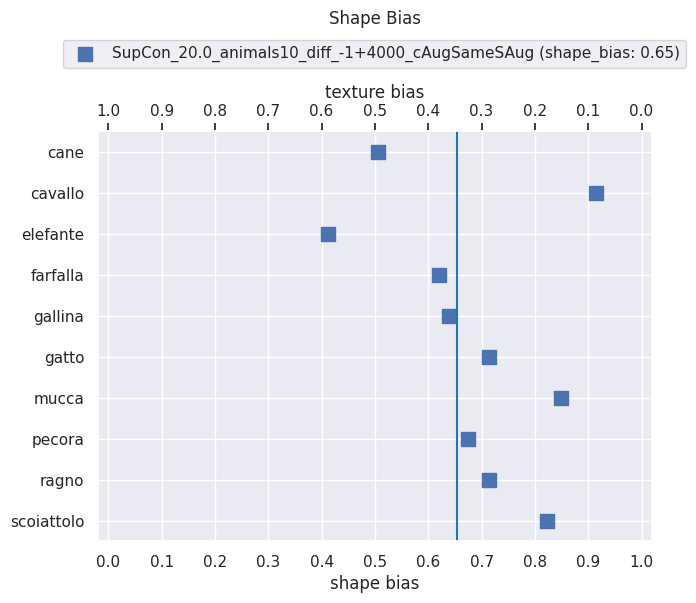

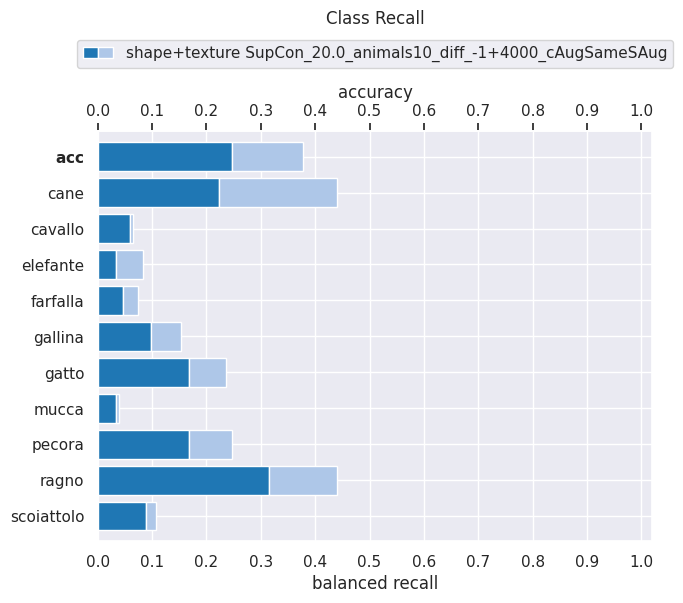

In [5]:
df_biases, class_biases = ut_sb.cue_conflict_shape_bias_metric_for_many(models_dict, root_dataset_conflict, cuda_device)
ut_sb.save_cue_conflict_shape_bias_to_csv_file_for_many(models_dict, df_biases, class_biases, dataset_cue_conflict, save_plots=True)

for m in models_dict:
    root_model, _ = models_dict[m]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    create_shape_bias_md(path_folder)

df_biases

### Correlation Coefficient Shape Bias

In [25]:
df_dims = corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)
df_dims

100%|██████████| 202/202 [02:03<00:00,  1.63it/s]


,shape_dims,texture_dims,color_dims,remaining_dims
CE_origAllAug,133,102,104,173
CE_diff4000AllAug,133,106,90,183
CE_diffAugAllAug,155,94,96,167
SupCon_baseline,129,105,101,177
SupCon_diffCSameSAug,155,92,94,171
SupConHybrid_diffColorAug,162,88,90,172
SupConFactor_factor5cAugSameSAug,163,87,88,174


In [28]:
df_dims.to_csv("./save/Validation/corrCoefShapeBias/colorAug_corrCoefShapeBias.csv")

-------------------

In [4]:
model_short_name = "SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug"

root_model = models_dict[model_short_name][0]

df_dims = ut_sb.corelation_coefficient_shape_bias_metric(root_model, model_short_name, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)
df_dims

100%|██████████| 202/202 [02:02<00:00,  1.66it/s]


,shape_dims,texture_dims,color_dims,remaining_dims
SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug,163,88,89,172


In [26]:
model_short_name = "SupConFactor_factor20cAugSameSAug"

root_model = models_dict[model_short_name][0]

df_dims = corelation_coefficient_shape_bias_metric(root_model, model_short_name, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)
df_dims

100%|██████████| 202/202 [02:03<00:00,  1.64it/s]


,shape_dims,texture_dims,color_dims,remaining_dims
SupConFactor_factor20cAugSameSAug,163,88,89,172


In [29]:
# after 200 epochs
model_short_name = "SupConFactor_factor20cAugSameSAug"

root_model = models_dict[model_short_name][0]

df_dims = corelation_coefficient_shape_bias_metric(root_model, model_short_name, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)
df_dims

100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


,shape_dims,texture_dims,color_dims,remaining_dims
SupConFactor_factor20cAugSameSAug,162,89,90,171


In [53]:
df_dims = corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)

100%|██████████| 202/202 [02:19<00:00,  1.44it/s]


In [54]:
# with colorJitter
df_dims

,shape_dims,texture_dims,color_dims,remaining_dims
CE_baseline,115,96,121,180
SupConFactor_factor5cAugSameSAug,163,87,88,174


In [45]:
# without colorJitter
df_dims

,shape_dims,texture_dims,color_dims,remaining_dims
CE_baseline,129,111,109,163
SupConFactor_factor5cAugSameSAug,165,87,86,174


### Feature Embedding Distances

In [ ]:
df_distances = ut_sb.compute_distance_to_diff_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, plot_hist=False)
ut_sb.save_dist_to_csv_file_for_many(models_dict, df_distances, dataset_orig, dataset_shape)

for m in models_dict:
    root_model, _ = models_dict[m]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    create_distances_md(path_folder)

df_distances